In [1]:
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
import numpy as np 
import gpplot as gpp
import matplotlib.pyplot as plt
gpp.set_aesthetics()

Looking at active vs inactive guides in TP53 tiling screen and seeing if they separate by FORECasT-BE editing efficiency model



In [2]:
#Reading in all data that will be used

# Z-scores from activity-based selection TP53 screen etoposide arm
ABE= pd.read_excel("../../required_data/TP53/ABE_activity_zscores.xlsx",sheet_name="Sheet1")
CBE= pd.read_excel("../../required_data/TP53/CBE_activity_zscores.xlsx",sheet_name="Sheet1")

#subset to positive controls: guides that introduce missense, nonsense, or splice site mutations 
poscon_mutations=["Missense","Nonsense","Splice site"]

ABE=ABE[ABE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)
CBE=CBE[CBE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)

#further subset to positive controls: remove guides that introduce benign mutations
#this reduces the chance that guides are falsely called inactive due to lack of depletion
ABE_benign_guides=pd.read_csv("../../required_data/TP53/ABE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
ABE=ABE[ABE["sgRNA Target Sequence"].isin(ABE_benign_guides)==False].reset_index(drop=True)
CBE_benign_guides=pd.read_csv("../../required_data/TP53/CBE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
CBE=CBE[CBE["sgRNA Target Sequence"].isin(CBE_benign_guides)==False].reset_index(drop=True)

#output as csv for input to FORECast https://elixir.ut.ee/forecast-be/ 
ABE[["sgRNA Target Sequence"]].to_csv("../../required_data/TP53/ABE_poscons_FORECasT_input.csv",index=False,header=False)
CBE[["sgRNA Target Sequence"]].to_csv("../../required_data/TP53/CBE_poscons_FORECasT_input.csv",index=False,header=False)

## Retrieving FORECasT scores

I ran the FORECasT-BE web tool in batch, supplying a csv of guide sequences separately for the ABE and CBE positive controls and leaving the optional parameters at their default values of Mean=0.5 and Standard Deviation=0.2.  

Batch mode states “work in progress. Certain features may not behave as expected” so taking results with a grain of salt


In [3]:
ABE_forecast=pd.read_csv("../../required_data/TP53/FORECasT_results_ABE_poscons_TP53.csv")
CBE_forecast=pd.read_csv("../../required_data/TP53/FORECasT_results_CBE_poscons_TP53.csv")

ABE_forecast_with_data= ABE.merge(ABE_forecast[["Sequence","Z-Score"]],left_on= "sgRNA Target Sequence",right_on="Sequence")
CBE_forecast_with_data= CBE.merge(CBE_forecast[["Sequence","Z-Score"]],left_on= "sgRNA Target Sequence",right_on="Sequence")

ABE_forecast_with_data["FORECasT"]=ABE_forecast_with_data["Z-Score"]
CBE_forecast_with_data["FORECasT"]=CBE_forecast_with_data["Z-Score"]


## Identify distribution of BEhive scores in active vs. inactive guides



In [4]:
def plot_active_inactive(z_cutoff, ax,activity_predictions_df):
    
    inactive_forecast=activity_predictions_df[(activity_predictions_df["Eto_RepAB_D21;z-score"]>=-z_cutoff)&(activity_predictions_df["Eto_RepAB_D21;z-score"]<=z_cutoff)]["FORECasT"].tolist()
    active_forecast=activity_predictions_df[activity_predictions_df["Eto_RepAB_D21;z-score"]<-z_cutoff]["FORECasT"].tolist()
        
    inactive_guide_forecast_df=pd.DataFrame({"FORECasT":inactive_forecast})
    active_guide_forecast_df=pd.DataFrame({"FORECasT":active_forecast})
    guide_forecast_df=pd.concat([inactive_guide_forecast_df,active_guide_forecast_df],keys=["Inactive Guides","Active Guides"]).reset_index().rename(columns={"level_0":"guide_cat"})
    
    nobs = [str(x) for x in [len(inactive_forecast),len(active_forecast)]]
    nobs = ["n=" + i for i in nobs]
    
    sns.boxplot(guide_forecast_df,x="guide_cat",y="FORECasT",color="royalblue",ax=ax)
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],1.1,
                nobs[tick],
                horizontalalignment='center',
                size='medium',
                color='black',
                weight='bold')
    
    annotator = Annotator(ax, [("Inactive Guides","Active Guides")], data=guide_forecast_df, x="guide_cat", y='FORECasT', order=["Inactive Guides","Active Guides"],verbose=False)
    annotator.configure(test='Mann-Whitney', text_format='simple',fontsize=16,verbose=1) #this shows test name, actual p value
    annotator.apply_and_annotate()
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Active guide cutoff: z< -"+str(z_cutoff) )

Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test two-sided, P_val:1.216e-04 U_stat=1.217e+04
Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test two-sided, P_val:3.852e-04 U_stat=1.201e+04
Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test two-sided, P_val:3.274e-03 U_stat=1.165e+04


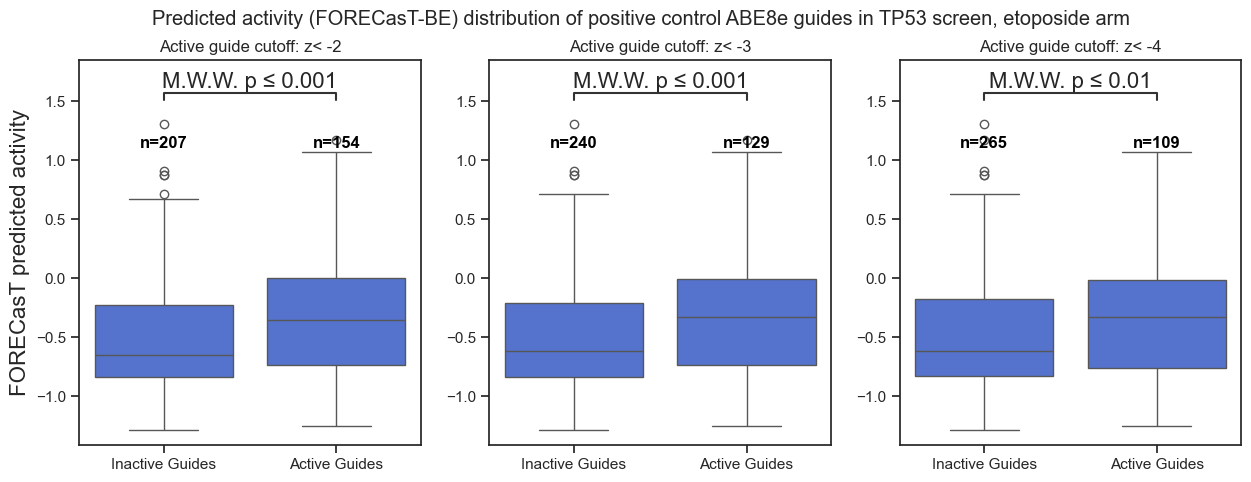

In [5]:
(fig,ax)=plt.subplots(1,3,figsize=(15,5))

plot_active_inactive(2,ax[0],ABE_forecast_with_data)
plot_active_inactive(3,ax[1],ABE_forecast_with_data)
plot_active_inactive(4,ax[2],ABE_forecast_with_data)

plt.suptitle("Predicted activity (FORECasT-BE) distribution of positive control ABE8e guides in TP53 screen, etoposide arm")
ax[0].set_ylabel("FORECasT predicted activity",fontsize=16)

#gpp.savefig("FORECasT_active_inactiveguides_ABE_TP53activitybased.pdf",bbox_inches="tight",dpi=600)

Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test two-sided, P_val:4.943e-01 U_stat=1.717e+04
Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test two-sided, P_val:5.733e-01 U_stat=1.682e+04
Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test two-sided, P_val:1.680e-01 U_stat=1.502e+04


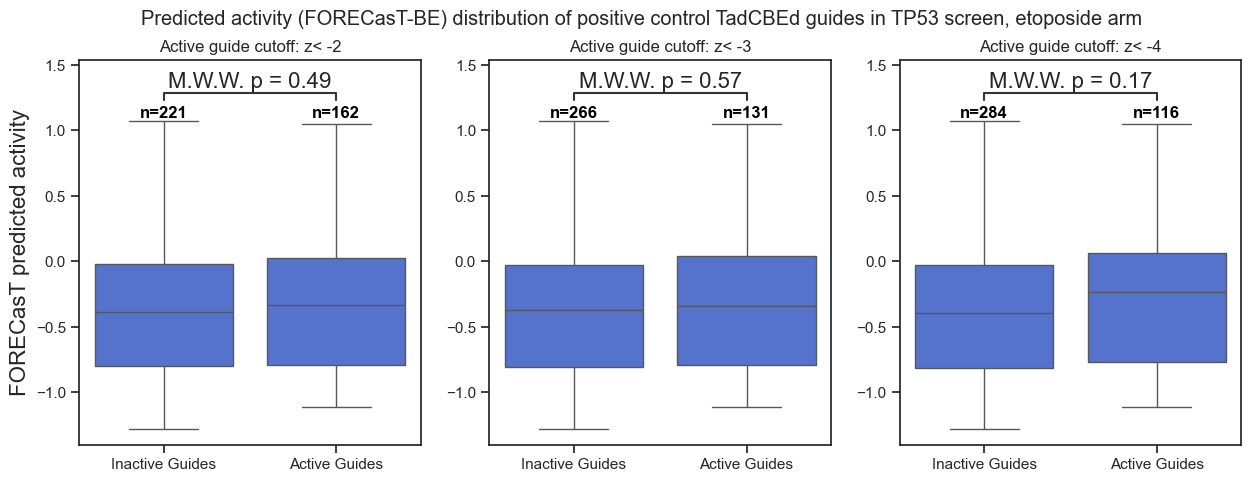

In [6]:
(fig,ax)=plt.subplots(1,3,figsize=(15,5))

plot_active_inactive(2,ax[0],CBE_forecast_with_data)
plot_active_inactive(3,ax[1],CBE_forecast_with_data)
plot_active_inactive(4,ax[2],CBE_forecast_with_data)

plt.suptitle("Predicted activity (FORECasT-BE) distribution of positive control TadCBEd guides in TP53 screen, etoposide arm")
ax[0].set_ylabel("FORECasT predicted activity",fontsize=16)

#gpp.savefig("FORECasT_active_inactiveguides_CBE_TP53activitybased.pdf",bbox_inches="tight",dpi=600)

<Axes: xlabel='FORECasT', ylabel='Eto_RepAB_D21;z-score'>

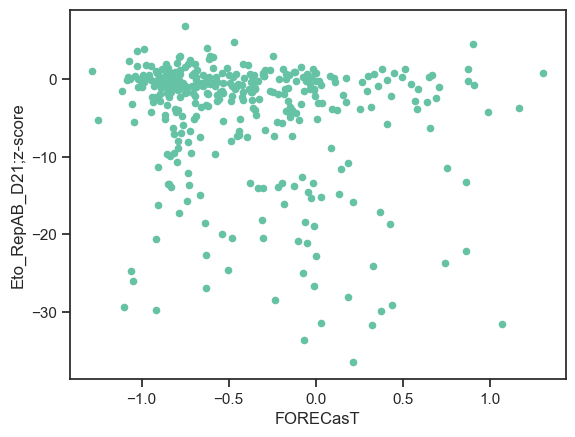

In [7]:
ABE_forecast_with_data.plot(x="FORECasT",y="Eto_RepAB_D21;z-score",kind="scatter")

<Axes: xlabel='FORECasT', ylabel='Eto_RepAB_D21;z-score'>

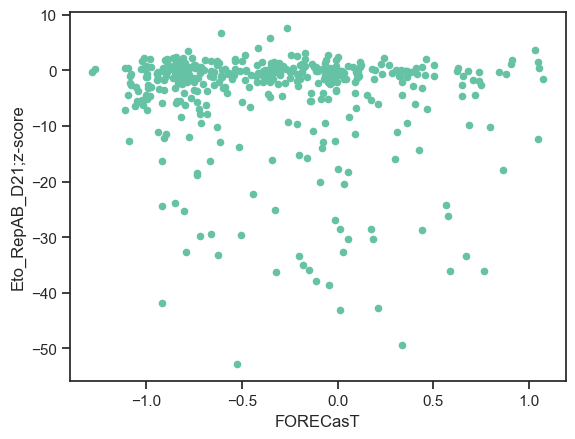

In [8]:
CBE_forecast_with_data.plot(x="FORECasT",y="Eto_RepAB_D21;z-score",kind="scatter")